In [1]:
pip install tensorflow
pip install seaborn

connection successful!


In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
import time
import seaborn as sns
from snowflake.snowpark.session import Session
import configparser

import warnings
warnings.filterwarnings("ignore")

config = configparser.ConfigParser()
config.read("snowflake_connection.ini")

connection_parameters = {
    "user": f'{config["Snowflake"]["user"]}',
    "password": f'{config["Snowflake"]["password"]}',
    "account": f'{config["Snowflake"]["account"]}',
    "WAREHOUSE": f'{config["Snowflake"]["WAREHOUSE"]}',
    "DATABASE": f'{config["Snowflake"]["DATABASE"]}',
    "SCHEMA": f'{config["Snowflake"]["SCHEMA"]}'
}

def snowflake_connector(conn):
    try:
        session = Session.builder.configs(conn).create()
        print("connection successful!")
    except:
        raise ValueError("error while connecting with db")
    return session

session = snowflake_connector(connection_parameters)

Matplotlib created a temporary cache directory at /tmp/matplotlib-7ej3kqg7 because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


connection successful!


In [2]:
df = session.table("CPG_WAREHOUSE").to_pandas()

In [3]:
df.head(5)

,DATE,WARE_HOUSE_ID,WH_MANAGER_ID,LOCATION_TYPE,WH_CAPACITY_SIZE,ZONE,WH_REGIONAL_ZONE,REFILL_REQUESTS,TRANSPORT_ISSUE,NO_OF_COMPETITOR,...,ELECTRIC_SUPPLY,DIST_FROM_HUB,WORKERS_NUM,WH_EST_YEAR,STORAGE_ISSUE_REPORTED,TEMP_REG_MACH,APPROVED_WH_GOVT_CERTIFICATE,WH_BREAKDOWN,GOVT_CHECK,PRODUCT_WG_TON
0,2023-01-01,WH_100000,EID_50000,Urban,Small,West,Zone 6,3,1,2,...,1,91,29.0,NaN,13,0.0,A,5.0,15.0,17115.0
1,2023-01-01,WH_100001,EID_50001,Rural,Large,North,Zone 5,0,0,4,...,1,210,31.0,NaN,4,0.0,A,3.0,17.0,5074.0
2,2023-01-01,WH_100002,EID_50002,Rural,Mid,South,Zone 2,1,0,4,...,0,161,37.0,NaN,17,0.0,A,6.0,22.0,23137.0
3,2023-01-01,WH_100003,EID_50003,Rural,Mid,North,Zone 3,7,4,2,...,0,103,21.0,NaN,17,1.0,A+,3.0,27.0,22115.0
4,2023-01-01,WH_100004,EID_50004,Rural,Large,North,Zone 5,3,1,2,...,1,112,25.0,2009.0,18,0.0,C,6.0,24.0,24071.0


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350001 entries, 0 to 350000
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   DATE                          350001 non-null  object 
 1   WARE_HOUSE_ID                 350001 non-null  object 
 2   WH_MANAGER_ID                 350001 non-null  object 
 3   LOCATION_TYPE                 350001 non-null  object 
 4   WH_CAPACITY_SIZE              350001 non-null  object 
 5   ZONE                          350001 non-null  object 
 6   WH_REGIONAL_ZONE              350001 non-null  object 
 7   REFILL_REQUESTS               350001 non-null  int8   
 8   TRANSPORT_ISSUE               350001 non-null  int8   
 9   NO_OF_COMPETITOR              350001 non-null  int8   
 10  NO_OF_RETAILERS               350001 non-null  int16  
 11  WAREHOUSE_OWNERSHIP           350001 non-null  object 
 12  NUMBER_OF_DISTRIBUTORS        350001 non-nul

In [5]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
REFILL_REQUESTS,350001.0,4.720761,3.648191,0.0,2.00,4.0,7.0,26.0
TRANSPORT_ISSUE,350001.0,2.426333,2.579299,0.0,0.00,2.0,4.0,22.0
NO_OF_COMPETITOR,350001.0,3.729101,2.997011,0.0,2.00,3.0,5.0,22.0
NO_OF_RETAILERS,350001.0,4985.876377,1285.713090,0.0,4141.00,4893.0,5724.0,12861.0
NUMBER_OF_DISTRIBUTORS,350001.0,61.922032,21.646701,8.0,46.00,62.0,77.0,146.0
FLOOD_IMPACTED,350001.0,0.098160,0.297531,0.0,0.00,0.0,0.0,1.0
FLOOD_PROOF,350001.0,0.054643,0.227282,0.0,0.00,0.0,0.0,1.0
ELECTRIC_SUPPLY,350001.0,0.656881,0.474752,0.0,0.00,1.0,1.0,1.0
DIST_FROM_HUB,350001.0,163.537113,62.717475,55.0,109.00,164.0,218.0,271.0
WORKERS_NUM,349011.0,37.665369,11.993045,0.0,30.00,37.0,45.0,124.0


In [6]:
df.duplicated().sum()

0

In [7]:
df.isnull().sum()

DATE                                 0
WARE_HOUSE_ID                        0
WH_MANAGER_ID                        0
LOCATION_TYPE                        0
WH_CAPACITY_SIZE                     0
ZONE                                 0
WH_REGIONAL_ZONE                     0
REFILL_REQUESTS                      0
TRANSPORT_ISSUE                      0
NO_OF_COMPETITOR                     0
NO_OF_RETAILERS                      0
WAREHOUSE_OWNERSHIP                  0
NUMBER_OF_DISTRIBUTORS               0
FLOOD_IMPACTED                       0
FLOOD_PROOF                          0
ELECTRIC_SUPPLY                      0
DIST_FROM_HUB                        0
WORKERS_NUM                        990
WH_EST_YEAR                     166335
STORAGE_ISSUE_REPORTED               0
TEMP_REG_MACH                        1
APPROVED_WH_GOVT_CERTIFICATE         1
WH_BREAKDOWN                         1
GOVT_CHECK                           1
PRODUCT_WG_TON                       1
dtype: int64

<Axes: >

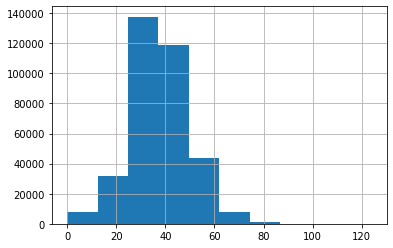

In [8]:
df['WORKERS_NUM'].hist()

In [9]:
df['WORKERS_NUM'] = df['WORKERS_NUM'].fillna(df['WORKERS_NUM'].mean())

APPROVED_WH_GOVT_CERTIFICATE
C     77014
B+    68837
B     67368
A     65395
A+    58674
NA    12712
0         1
Name: count, dtype: int64

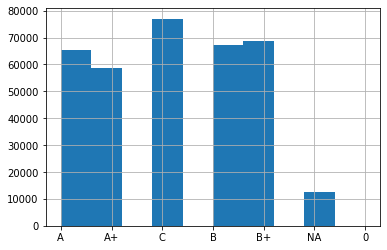

In [21]:
df['APPROVED_WH_GOVT_CERTIFICATE'].hist()
df['APPROVED_WH_GOVT_CERTIFICATE'].value_counts()

In [22]:
df.isnull().sum()


DATE                                 0
WARE_HOUSE_ID                        0
WH_MANAGER_ID                        0
LOCATION_TYPE                        0
WH_CAPACITY_SIZE                     0
ZONE                                 0
WH_REGIONAL_ZONE                     0
REFILL_REQUESTS                      0
TRANSPORT_ISSUE                      0
NO_OF_COMPETITOR                     0
NO_OF_RETAILERS                      0
WAREHOUSE_OWNERSHIP                  0
NUMBER_OF_DISTRIBUTORS               0
FLOOD_IMPACTED                       0
FLOOD_PROOF                          0
ELECTRIC_SUPPLY                      0
DIST_FROM_HUB                        0
WORKERS_NUM                          0
WH_EST_YEAR                     166335
STORAGE_ISSUE_REPORTED               0
TEMP_REG_MACH                        1
APPROVED_WH_GOVT_CERTIFICATE         0
WH_BREAKDOWN                         1
GOVT_CHECK                           1
PRODUCT_WG_TON                       1
dtype: int64

APPROVED_WH_GOVT_CERTIFICATE
C     77014
B+    68837
B     67368
A     65395
A+    58674
NA    12712
0         1
Name: count, dtype: int64

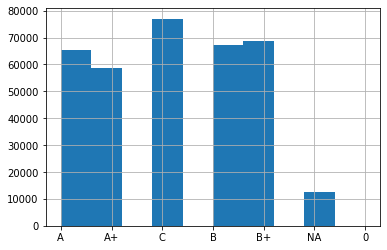

In [23]:
df['APPROVED_WH_GOVT_CERTIFICATE'].hist()
df['APPROVED_WH_GOVT_CERTIFICATE'].value_counts()

In [24]:
df['APPROVED_WH_GOVT_CERTIFICATE']=df['APPROVED_WH_GOVT_CERTIFICATE'].fillna(method='ffill')

[Text(0.5, 1.0, 'Location Type by zone')]

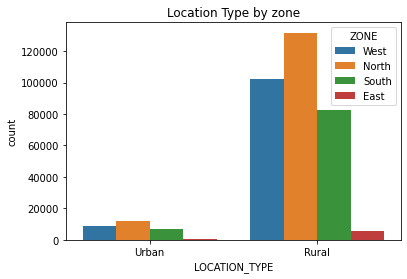

In [25]:
sns.countplot(data=df,x='LOCATION_TYPE',hue='ZONE').set(title='Location Type by zone')

<Axes: xlabel='APPROVED_WH_GOVT_CERTIFICATE', ylabel='WH_BREAKDOWN'>

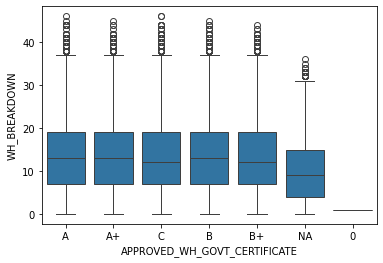

In [26]:
sns.boxplot(data=df,x='APPROVED_WH_GOVT_CERTIFICATE',y='WH_BREAKDOWN')

In [27]:
df.head(5)

,DATE,WARE_HOUSE_ID,WH_MANAGER_ID,LOCATION_TYPE,WH_CAPACITY_SIZE,ZONE,WH_REGIONAL_ZONE,REFILL_REQUESTS,TRANSPORT_ISSUE,NO_OF_COMPETITOR,...,ELECTRIC_SUPPLY,DIST_FROM_HUB,WORKERS_NUM,WH_EST_YEAR,STORAGE_ISSUE_REPORTED,TEMP_REG_MACH,APPROVED_WH_GOVT_CERTIFICATE,WH_BREAKDOWN,GOVT_CHECK,PRODUCT_WG_TON
0,2023-01-01,WH_100000,EID_50000,Urban,Small,West,Zone 6,3,1,2,...,1,91,29.0,NaN,13,0.0,A,5.0,15.0,17115.0
1,2023-01-01,WH_100001,EID_50001,Rural,Large,North,Zone 5,0,0,4,...,1,210,31.0,NaN,4,0.0,A,3.0,17.0,5074.0
2,2023-01-01,WH_100002,EID_50002,Rural,Mid,South,Zone 2,1,0,4,...,0,161,37.0,NaN,17,0.0,A,6.0,22.0,23137.0
3,2023-01-01,WH_100003,EID_50003,Rural,Mid,North,Zone 3,7,4,2,...,0,103,21.0,NaN,17,1.0,A+,3.0,27.0,22115.0
4,2023-01-01,WH_100004,EID_50004,Rural,Large,North,Zone 5,3,1,2,...,1,112,25.0,2009.0,18,0.0,C,6.0,24.0,24071.0


In [29]:
from sklearn.preprocessing import LabelEncoder

In [30]:
#label encoder turns label into numeric data
le = LabelEncoder()
df['LOCATION_TYPE']=le.fit_transform(df['LOCATION_TYPE'])
df['WH_CAPACITY_SIZE']=le.fit_transform(df['WH_CAPACITY_SIZE'])
df['APPROVED_WH_GOVT_CERTIFICATE']=le.fit_transform(df['APPROVED_WH_GOVT_CERTIFICATE'])
df['ZONE']=le.fit_transform(df['ZONE'])
df['WH_REGIONAL_ZONE']= le.fit_transform(df['WH_REGIONAL_ZONE'])
df['WAREHOUSE_OWNERSHIP']=le.fit_transform(df['WAREHOUSE_OWNERSHIP'])
## can also use the code below to transform into numeric data by removing "Zone" using lambda expression
##df['WH_regional_zone']=df['WH_regional_zone'].apply(lambda x: x.split(' ')[1]-1)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350001 entries, 0 to 350000
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   DATE                          350001 non-null  object 
 1   WARE_HOUSE_ID                 350001 non-null  object 
 2   WH_MANAGER_ID                 350001 non-null  object 
 3   LOCATION_TYPE                 350001 non-null  int64  
 4   WH_CAPACITY_SIZE              350001 non-null  int64  
 5   ZONE                          350001 non-null  int64  
 6   WH_REGIONAL_ZONE              350001 non-null  int64  
 7   REFILL_REQUESTS               350001 non-null  int8   
 8   TRANSPORT_ISSUE               350001 non-null  int8   
 9   NO_OF_COMPETITOR              350001 non-null  int8   
 10  NO_OF_RETAILERS               350001 non-null  int16  
 11  WAREHOUSE_OWNERSHIP           350001 non-null  int64  
 12  NUMBER_OF_DISTRIBUTORS        350001 non-nul

In [31]:
df = df.drop(['WARE_HOUSE_ID','WH_MANAGER_ID','DATE'],axis=1)

<Axes: >

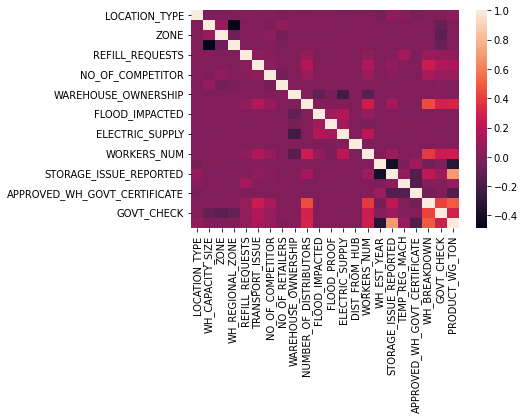

In [32]:
sns.heatmap(df.corr())


In [33]:
X = df.drop('APPROVED_WH_GOVT_CERTIFICATE',axis=1).values
y = df['APPROVED_WH_GOVT_CERTIFICATE'].values

In [36]:
y = df['APPROVED_WH_GOVT_CERTIFICATE'].values

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
scaler = MinMaxScaler().fit(X_train)
X_train= scaler.transform(X_train)
X_test= scaler.transform(X_test)

In [37]:
print('X train shape: ',X_train.shape)
print('X test shape: ',X_test.shape)

X train shape:  (280000, 21)
X test shape:  (70001, 21)


In [48]:
y.head(5)

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [41]:
#define a deep learning model
model = Sequential()

#20 neurons first layer because 20 inputs
model.add(Dense(20,activation='relu'))

model.add(Dense(10,activation='relu'))
model.add(Dense(10,activation='relu'))

#5 neurons for last layer because 5 classes (grade of govt certificate)
model.add(Dense(7,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
#fit the model with data
history = model.fit(x=X_train,
          y=y_train, epochs=300,
          validation_data=(X_test, y_test), verbose=1
          )

Epoch 1/300
8750/8750 [==============================] - 17s 2ms/step - loss: nan - accuracy: 1.7857e-05 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/300
8750/8750 [==============================] - 16s 2ms/step - loss: nan - accuracy: 3.5714e-06 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/300
8750/8750 [==============================] - 16s 2ms/step - loss: nan - accuracy: 3.5714e-06 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/300
8750/8750 [==============================] - 16s 2ms/step - loss: nan - accuracy: 3.5714e-06 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/300
8750/8750 [==============================] - 16s 2ms/step - loss: nan - accuracy: 3.5714e-06 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/300
8750/8750 [==============================] - 16s 2ms/step - loss: nan - accuracy: 3.5714e-06 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/300
8750/8750 [==============================] - 16s 2ms/step - loss: nan - accuracy: 3.5714e-06 - val_l